# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.404397,True,8.080161
1,0.751381,True,6.466268
2,-0.653535,True,5.134339
3,1.301846,True,5.915189
4,-1.025060,False,-1.301817
...,...,...,...
995,-0.432951,False,-1.511095
996,1.323255,True,5.905153
997,0.224690,False,1.229888
998,1.403730,True,7.478528


<Axes: xlabel='v0'>

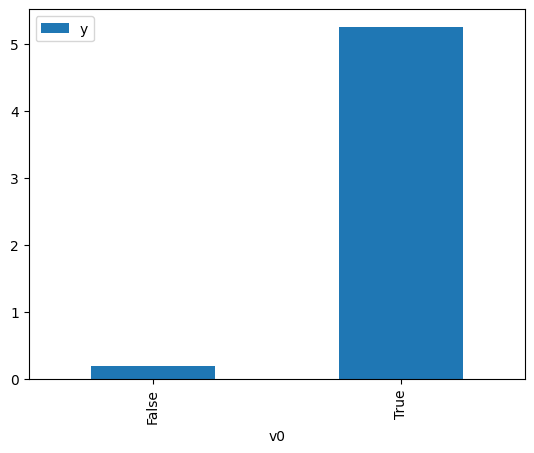

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

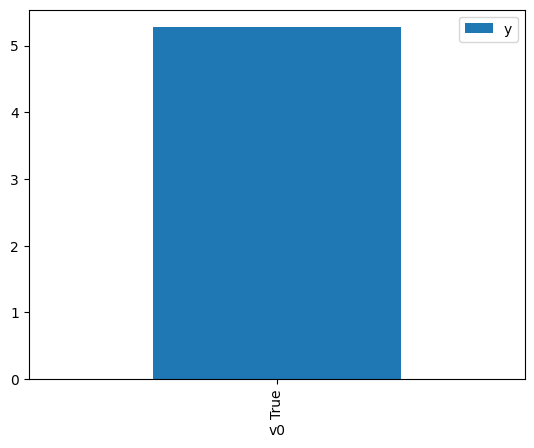

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.028677,False,-2.470328,0.900403,1.110613
1,0.213444,False,-0.206011,0.359027,2.785307
2,-0.418499,False,-0.395189,0.697502,1.433688
3,1.487509,False,3.571227,0.031297,31.951471
4,0.995196,False,-0.077418,0.088664,11.278515
...,...,...,...,...,...
995,0.904462,False,2.476156,0.106511,9.388714
996,0.245431,False,1.584834,0.342716,2.917866
997,-0.319408,False,-0.313500,0.648750,1.541425
998,-0.526475,False,-0.832035,0.745965,1.340546


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.250238,True,4.893922,0.659704,1.515831
1,-0.339593,True,4.362884,0.341021,2.932373
2,0.992460,True,5.119889,0.910840,1.097888
3,-0.200631,True,6.959066,0.413967,2.415652
4,0.047248,True,4.431036,0.551678,1.812653
...,...,...,...,...,...
995,0.645239,True,5.439265,0.824400,1.213004
996,0.222152,True,5.675716,0.645447,1.549313
997,-0.497374,True,3.120485,0.266580,3.751217
998,-1.723892,True,2.072908,0.022789,43.880230


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.955
Model:                            OLS   Adj. R-squared (uncentered):              0.955
Method:                 Least Squares   F-statistic:                          1.050e+04
Date:                Tue, 05 Nov 2024   Prob (F-statistic):                        0.00
Time:                        16:47:59   Log-Likelihood:                         -1452.9
No. Observations:                1000   AIC:                                      2910.
Df Residuals:                     998   BIC:                                      2920.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.6161      0.038     42.545      0.000       1.542       1.691
x2             5.0199      0.051     98.372      0.000       4.920       5.120
==============================================================================
Omnibus:                        1.758   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.415   Jarque-Bera (JB):                1.657
Skew:                           0.014   Prob(JB):                        0.437
Kurtosis:                       2.802   Cond. No.                         1.88
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""